Autoencoder

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import os
import glob
import matplotlib.image as mpimg

2024-07-02 16:48:22.640393: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 16:48:22.824656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 16:48:22.923705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 16:48:22.924280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 16:48:23.068440: I tensorflow/core/platform/cpu_feature_gua

In [2]:

# Verificar si TensorFlow reconoce la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow reconoce las siguientes GPU:")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("TensorFlow no reconoce ninguna GPU")

TensorFlow reconoce las siguientes GPU:
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-07-02 16:48:25.441575: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 16:48:25.576632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 16:48:25.576671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Carga de datos

In [3]:
def leer_jpg_de_subcarpetas(carpeta_principal):
    # Obtener todas las rutas de archivos .jpg en todas las subcarpetas
    rutas_jpg = glob.glob(os.path.join(carpeta_principal, '**', '*.jpg'), recursive=True)
    
    return rutas_jpg

def load_files(files_list):
    data=[]
    for file_path in files_list:
        img=cv2.imread(file_path)
        data.append(img)
    return data

In [4]:
path='/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Image_autoencoder/Dataset'
jpg_path=leer_jpg_de_subcarpetas(path)
print(len(jpg_path))

9997


In [5]:
data=[]
print(len(jpg_path))
batch_size=len(jpg_path)//13
step=0
for i in range(13):
    data+=load_files(jpg_path[step:batch_size+step])
    step+=batch_size

9997


Exploración de los datos


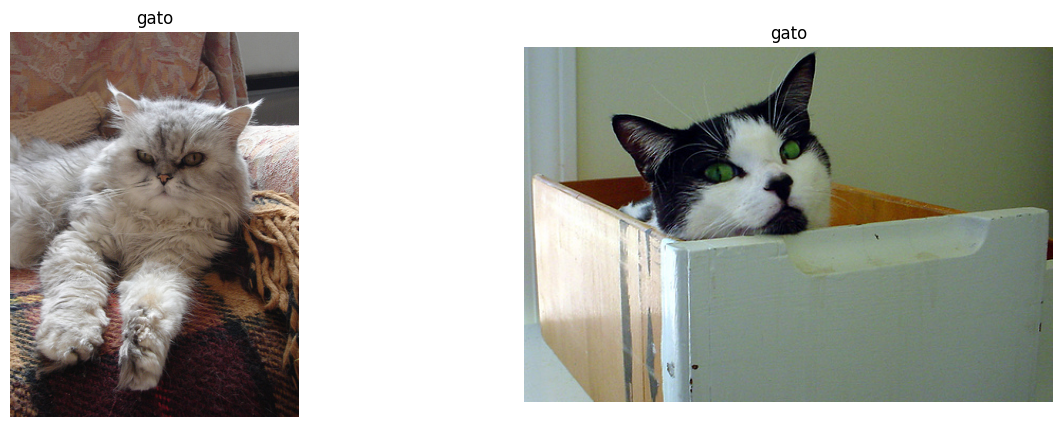

In [22]:
def show_images(image_paths, titles):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Ajustar el tamaño de la figura según el número de imágenes
    for i in range(num_images):
        # Cargar la imagen y convertirla a RGB
        image = cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB)
        # Mostrar la imagen en la subtrama correspondiente
        axes[i].imshow(image)
        axes[i].axis('off')  # Desactivar los ejes
        axes[i].set_title(titles[i])  # Establecer el título de la subtrama
    plt.show()
    
def show_loaded_images(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Ajustar el tamaño de la figura según el número de imágenes
    
    for i in range(num_images):
        # Convertir la imagen de BGR a RGB
        image_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        
        # Mostrar la imagen en la subtrama correspondiente
        axes[i].imshow(image_rgb)
        axes[i].axis('off')  # Desactivar los ejes
        axes[i].set_title(titles[i])  # Establecer el título de la subtrama
    
    plt.show()
image_paths = [jpg_path[0], jpg_path[8000]]
titles = ['gato', 'gato']
show_images(image_paths, titles)

Normalizado de los datos

In [23]:
def shape_fix(img):
    if img.shape[1]<img.shape[0]:
        image=img[0:img.shape[1],0:img.shape[1]]
    elif img.shape[1]>img.shape[0]:
        image=img[0:img.shape[0],0:img.shape[0]]
    else:
        image=img
    return cv2.resize(image,(128,128))

In [24]:
fixed_images=[shape_fix(image) for image in data]

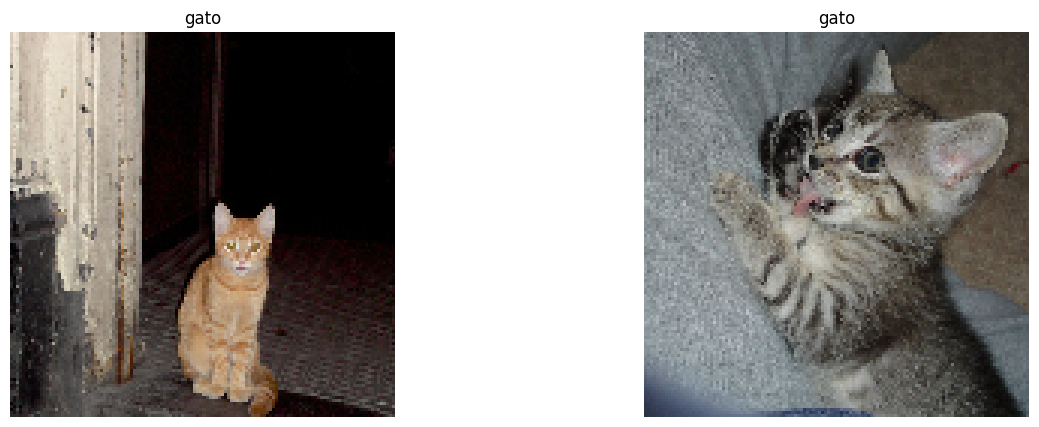

In [25]:
show_loaded_images((fixed_images[400],fixed_images[250]),['gato','gato'])

In [26]:
for image in fixed_images:
    image=image/255
    image=tf.convert_to_tensor(image,dtype=tf.float32)

Modelo

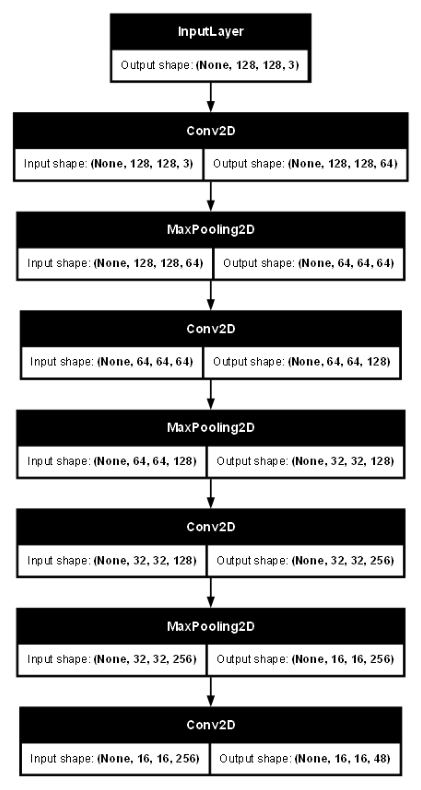

In [27]:
#Encoder
input_layer=tf.keras.layers.Input((128,128,3))

X=tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(input_layer)
X=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(X)
X=tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(X)
X=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(X)
X=tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same')(X)
X=tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(X)
X=tf.keras.layers.Conv2D(filters=48,kernel_size=(1,1),activation='relu',padding='same')(X)

encoder=tf.keras.Model(inputs=input_layer, outputs=X)

tf.keras.utils.plot_model(encoder,to_file='encoder.png', show_shapes=True, dpi=64,show_dtype=False)
Latent_size=(16,16,48)
img = mpimg.imread('/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Image_autoencoder/encoder.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()



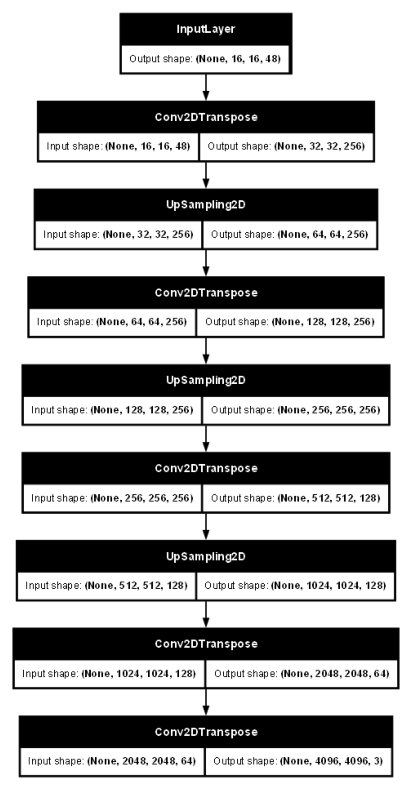

In [28]:


input_layer2=tf.keras.layers.Input(shape=encoder.output_shape[1:])
Y=tf.keras.layers.Conv2DTranspose(256,(1,1),activation='relu',padding='same',strides=2)(input_layer2)
Y=tf.keras.layers.UpSampling2D((2,2))(Y)
Y=tf.keras.layers.Conv2DTranspose(256,(3,3),activation='relu',padding='same',strides=2)(Y)
Y=tf.keras.layers.UpSampling2D((2,2))(Y)
Y=tf.keras.layers.Conv2DTranspose(128,(3,3),activation='relu',padding='same',strides=2)(Y)
Y=tf.keras.layers.UpSampling2D((2,2))(Y)
Y=tf.keras.layers.Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=2)(Y)
Y=tf.keras.layers.Conv2DTranspose(3,(3,3),activation='sigmoid',padding='same',strides=2)(Y)

decoder=tf.keras.Model(inputs=input_layer2,outputs=Y)

tf.keras.utils.plot_model(decoder,to_file='decoder.png', show_shapes=True, dpi=64,show_dtype=False)
Latent_size=(16,16,48)
img = mpimg.imread('/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Image_autoencoder/decoder.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

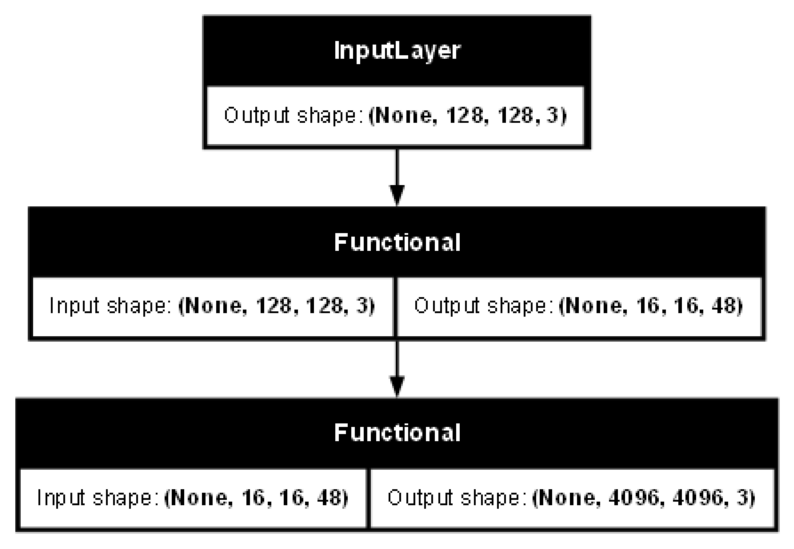

In [29]:
encoded=encoder(input_layer)
decoded=decoder(encoded)
Autoencoder=tf.keras.models.Model(input_layer,decoded)
tf.keras.utils.plot_model(Autoencoder,to_file='autoencoder.png', show_shapes=True, dpi=64,show_dtype=False)
Latent_size=(16,16,48)
img = mpimg.imread('/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Image_autoencoder/autoencoder.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
Autoencoder.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['mse','accuracy'])

Entrenamiento

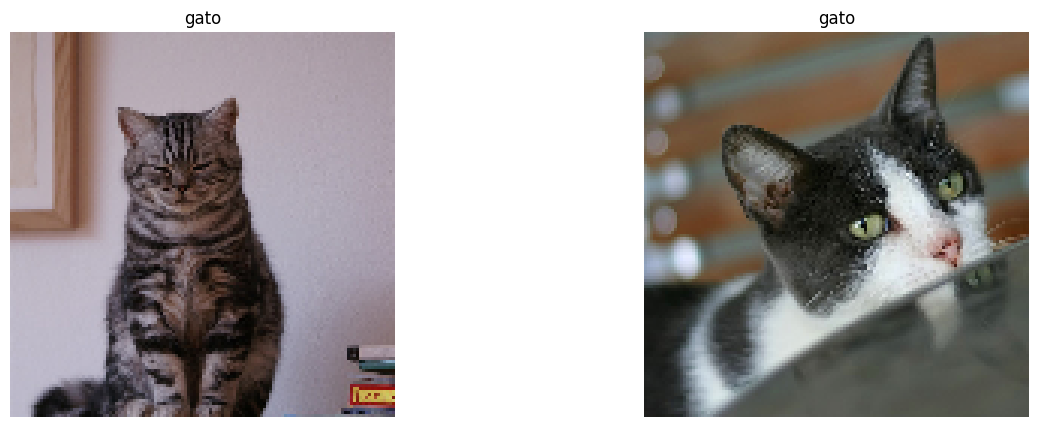

In [15]:
np.random.shuffle(fixed_images)
#print(len(data))
show_loaded_images((fixed_images[0],fixed_images[9000]),['gato','gato'])


In [17]:
X_train,X_test,_,_=train_test_split(fixed_images,fixed_images,test_size=.2,random_state=42)
X_test,X_valid,_,_=train_test_split(X_test,X_test,test_size=.2,random_state=42)

7997
1600
400


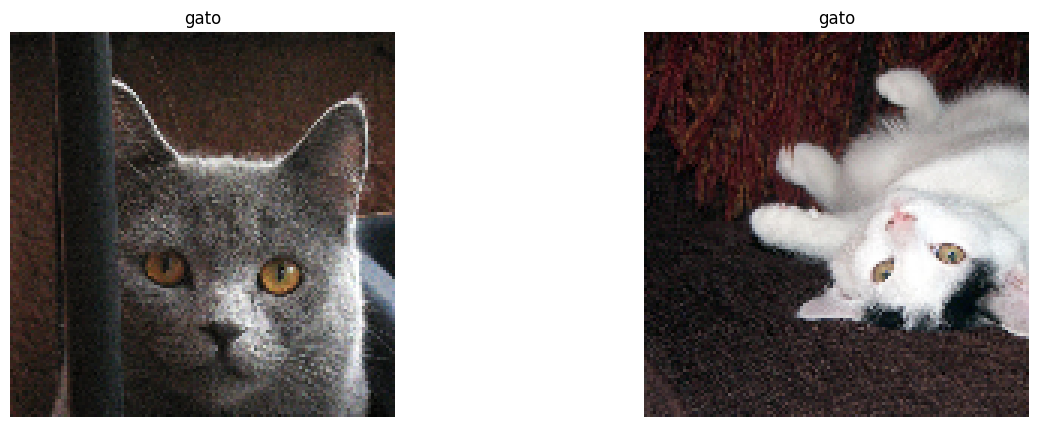

In [18]:
print(len(X_train))
print(len(X_test))
print(len(X_valid))
show_loaded_images((X_train[0],X_test[1500]),['gato','gato'])

In [19]:
X_train=np.array(X_train)
X_test=np.array(X_test)
X_valid=np.array(X_valid)

In [20]:
print(X_train[600].shape)

(128, 128, 3)


In [30]:
"""

#LOSS
LAMBDA=100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def autoencoder_loss(aut_enc_generated_output, gen_output, target):
  aut_enc_loss = loss_object(tf.ones_like(aut_enc_generated_output), aut_enc_generated_output)
  return aut_enc_loss

optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



@tf.function
def train_step(input_image,step):
    with tf.GradientTape() as aut_enc_tape:
        aut_enc_prediction=Autoencoder(input_image,training=True)
        loss=autoencoder_loss(aut_enc_prediction,input_image)
        autoencoder_gradient=aut_enc_tape.gradient(zip(loss,
                                                       Autoencoder.trainable_variables))
        optimizer.apply_gradients(zip(autoencoder_gradient,
                                      Autoencoder.trainable_variables))
        
        tf.summary.scalar('Loss', loss, step=step//1000)
        
        """

In [31]:
"""
def fit(train,steps):
    for step,input_image in train.repeat(1).take(steps).enumerate():
        train_step(input_image,input_image,step)
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)
"""

In [32]:
#batch_size=200
#fit(X_train,steps=100)

AttributeError: 'numpy.uint8' object has no attribute 'enumerate'

In [21]:
History= Autoencoder.fit(X_train,X_train,epochs=25,shuffle=True,validation_data=(X_valid,X_valid))

Epoch 1/25


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 128, 128, 3), output.shape=(None, 4096, 4096, 3)

In [ ]:
print(X_test[1].shape)
val=Autoencoder.predict(X_train)


(128, 128, 3)
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


: 

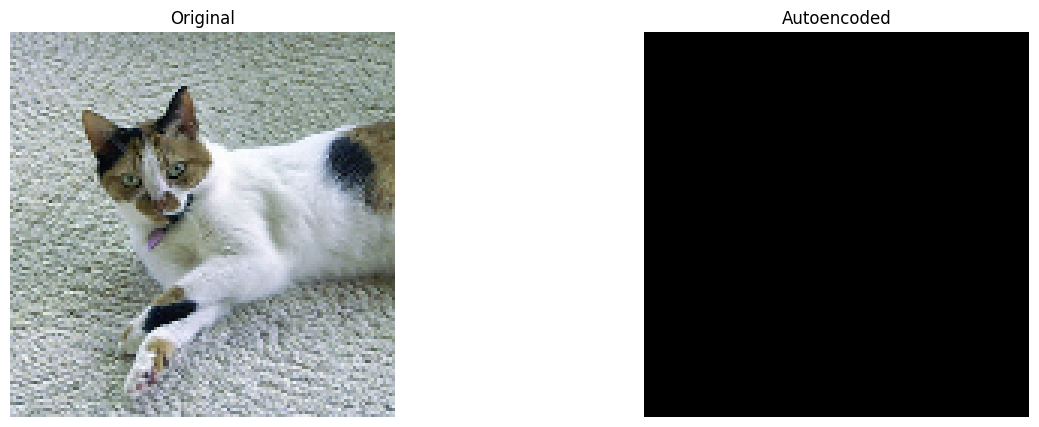

In [ ]:
show_loaded_images((X_train[100],val[100]),['Original','Autoencoded'])